# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Check GPU
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(1))

2
NVIDIA GeForce RTX 3090


# Part C 

## Implement Custom Resnet + Group Normalization

In [13]:
class CustomResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_groups=32):
        super(CustomResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.gn1 = nn.GroupNorm(num_groups, out_channels)
        self.elu = nn.ELU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.gn2 = nn.GroupNorm(num_groups, out_channels)

    def forward(self, x):
        shortcut = x
        x = self.conv1(x)
        x = self.gn1(x)
        x = self.elu(x)
        x = self.conv2(x)
        x = self.gn2(x)
        x += shortcut
        x = self.elu(x)
        return x
    
class CustomResNet_GN(nn.Module):
    def __init__(self, num_groups=32):
        super(CustomResNet_GN, self).__init__()
        # Initial convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.gn1 = nn.GroupNorm(num_groups, 32)
        self.elu1 = nn.ELU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.gn2 = nn.GroupNorm(num_groups, 64)
        self.elu2 = nn.ELU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        # Residual blocks
        self.resblock1 = CustomResNetBlock(64, 64, num_groups)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.gn3 = nn.GroupNorm(num_groups, 128)
        self.elu3 = nn.ELU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.gn4 = nn.GroupNorm(num_groups, 256)
        self.elu4 = nn.ELU()
        self.resblock2 = CustomResNetBlock(256, 256, num_groups)
        
        # Average pooling and fully connected layers
        self.avgpool = nn.AvgPool2d(kernel_size=3, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.gn1(x)
        x = self.elu1(x)
        x = self.conv2(x)
        x = self.gn2(x)
        x = self.elu2(x)
        x = self.maxpool1(x)
        
        x = self.resblock1(x)
        x = self.conv3(x)
        x = self.gn3(x)
        x = self.elu3(x)
        x = self.maxpool2(x)
        
        x = self.conv4(x)
        x = self.gn4(x)
        x = self.elu4(x)
        x = self.maxpool3(x)
        x = self.resblock2(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x
    

## Load Dataset

In [14]:
# Data augmentation and normalization
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# # Data augmentation and normalization for training
# transform_train = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(15),
#     transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
#     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [15]:
# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Splitting train dataset into train and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## Optimizer and Train Setup

In [16]:
# Model, optimizer, and scheduler
model = CustomResNet_GN()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=40, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [17]:
# Determine if CUDA is available and set the device accordingly
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model.to(device)

CustomResNet_GN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (gn1): GroupNorm(32, 32, eps=1e-05, affine=True)
  (elu1): ELU(alpha=1.0)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (gn2): GroupNorm(32, 64, eps=1e-05, affine=True)
  (elu2): ELU(alpha=1.0)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (resblock1): CustomResNetBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (gn1): GroupNorm(32, 64, eps=1e-05, affine=True)
    (elu): ELU(alpha=1.0)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (gn2): GroupNorm(32, 64, eps=1e-05, affine=True)
  )
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (gn3): GroupNorm(32, 128, eps=1e-05, affine=True)
  (elu3): ELU(alpha=1.0)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d

In [18]:
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = 100 * correct / total
    return train_loss, train_accuracy

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()
            _, predicted = output.max(1)
            correct += predicted.eq(target).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

# Training loop with tracking of training and validation accuracies
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
best_val_accuracy = 0
best_model_weights = None


In [20]:
for epoch in range(1, 101):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer , criterion)
    val_loss, val_accuracy = test(model, device, val_loader , criterion)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_weights = model.state_dict()

    print(f'Epoch: {epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    scheduler.step()

Epoch: 1, Train Loss: 1.9472, Train Accuracy: 51.78%, Val Loss: 1.9243, Val Accuracy: 53.90%
Epoch: 2, Train Loss: 1.8998, Train Accuracy: 56.56%, Val Loss: 1.8620, Val Accuracy: 60.54%
Epoch: 3, Train Loss: 1.8708, Train Accuracy: 59.39%, Val Loss: 1.8694, Val Accuracy: 59.30%
Epoch: 4, Train Loss: 1.8438, Train Accuracy: 62.12%, Val Loss: 1.8379, Val Accuracy: 62.46%
Epoch: 5, Train Loss: 1.8294, Train Accuracy: 63.39%, Val Loss: 1.8350, Val Accuracy: 62.52%
Epoch: 6, Train Loss: 1.8084, Train Accuracy: 65.54%, Val Loss: 1.7998, Val Accuracy: 66.34%
Epoch: 7, Train Loss: 1.8013, Train Accuracy: 66.29%, Val Loss: 1.7960, Val Accuracy: 66.54%
Epoch: 8, Train Loss: 1.7942, Train Accuracy: 66.95%, Val Loss: 1.7920, Val Accuracy: 66.96%
Epoch: 9, Train Loss: 1.7803, Train Accuracy: 68.30%, Val Loss: 1.7867, Val Accuracy: 67.50%
Epoch: 10, Train Loss: 1.7783, Train Accuracy: 68.36%, Val Loss: 1.7883, Val Accuracy: 67.38%
Epoch: 11, Train Loss: 1.7725, Train Accuracy: 68.96%, Val Loss: 1.77

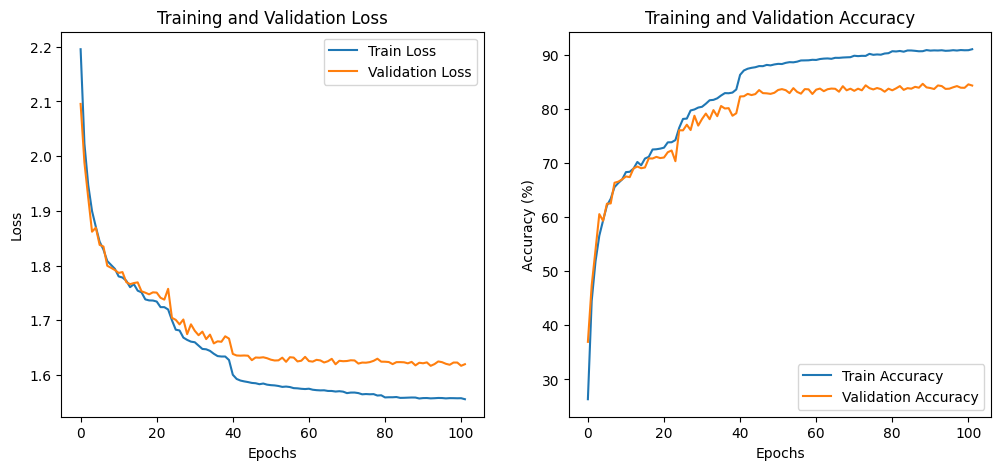

Best Validation Accuracy: 84.62%
Test Accuracy of the final model: 84.86%


In [21]:
# Load best model weights and evaluate on test set
model.load_state_dict(best_model_weights)
test_loss, test_accuracy = test(model, device, test_loader , criterion)

# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# Print best validation accuracy and test accuracy
print(f'Best Validation Accuracy: {best_val_accuracy:.2f}%')
print(f'Test Accuracy of the final model: {test_accuracy:.2f}%')

# Save best model weights
torch.save(best_model_weights, 'best_custom_resnet_weights_GN.pth')

# Layer Wise analyse , Part C

In [ ]:
# download Pretrained Weight of model
import gdown
id = "1Du8QY70d90wIPvrLip_Q3trsyeLvdE9L"
gdown.download(id=id, quiet=False)

In [ ]:
!git clone https://github.com/Arhosseini77/data_complexity_measures

In [3]:
from data_complexity_measures.models.ARH_SeparationIndex import ARH_SeparationIndex

In [4]:
class CustomResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_groups=32):
        super(CustomResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.gn1 = nn.GroupNorm(num_groups, out_channels)
        self.elu = nn.ELU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.gn2 = nn.GroupNorm(num_groups, out_channels)

    def forward(self, x):
        shortcut = x
        x = self.conv1(x)
        x = self.gn1(x)
        x = self.elu(x)
        x = self.conv2(x)
        x = self.gn2(x)
        x += shortcut
        x = self.elu(x)
        return x
    
class CustomResNet_GN(nn.Module):
    def __init__(self, num_groups=32):
        super(CustomResNet_GN, self).__init__()
        # Initial convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.gn1 = nn.GroupNorm(num_groups, 32)
        self.elu1 = nn.ELU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.gn2 = nn.GroupNorm(num_groups, 64)
        self.elu2 = nn.ELU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        # Residual blocks
        self.resblock1 = CustomResNetBlock(64, 64, num_groups)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.gn3 = nn.GroupNorm(num_groups, 128)
        self.elu3 = nn.ELU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.gn4 = nn.GroupNorm(num_groups, 256)
        self.elu4 = nn.ELU()
        self.resblock2 = CustomResNetBlock(256, 256, num_groups)
        
        # Average pooling and fully connected layers
        self.avgpool = nn.AvgPool2d(kernel_size=3, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.gn1(x)
        x = self.elu1(x)
        x = self.conv2(x)
        x = self.gn2(x)
        x = self.elu2(x)
        x = self.maxpool1(x)
        
        x = self.resblock1(x)
        x = self.conv3(x)
        x = self.gn3(x)
        x = self.elu3(x)
        x = self.maxpool2(x)
        
        x = self.conv4(x)
        x = self.gn4(x)
        x = self.elu4(x)
        x = self.maxpool3(x)
        x = self.resblock2(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x
    

In [5]:
# Data augmentation and normalization
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [6]:
# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Splitting train dataset into train and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])


# Further split train_dataset into train_loader_dataset and 20% balanced subset
train_loader_dataset, _ = train_test_split(train_dataset.dataset, train_size=int(0.15 * len(train_dataset)),
                                           test_size=None, shuffle=True, stratify=train_dataset.dataset.targets)

# Data loaders
train_loader = DataLoader(train_loader_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# Instantiate and load the model
model = CustomResNet_GN()  # Make sure CustomResNet is defined as earlier
model.load_state_dict(torch.load('best_custom_resnet_weights_GN.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

CustomResNet_GN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (gn1): GroupNorm(32, 32, eps=1e-05, affine=True)
  (elu1): ELU(alpha=1.0)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (gn2): GroupNorm(32, 64, eps=1e-05, affine=True)
  (elu2): ELU(alpha=1.0)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (resblock1): CustomResNetBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (gn1): GroupNorm(32, 64, eps=1e-05, affine=True)
    (elu): ELU(alpha=1.0)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (gn2): GroupNorm(32, 64, eps=1e-05, affine=True)
  )
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (gn3): GroupNorm(32, 128, eps=1e-05, affine=True)
  (elu3): ELU(alpha=1.0)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d

In [8]:
# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'softmax', 'flatten', 'fc1', 'fc2'}

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

## SI and CenterSI layer for Train Loader

In [8]:
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader):
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        # Flatten and concatenate the features for each layer
        features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
    else:
        print(f"No features captured for layer {layer_name}")

# Concatenate the labels
labels = torch.cat(labels_list)

100%|██████████| 40/40 [00:01<00:00, 25.43it/s]


### Calc SI

In [9]:
si_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    si = instance_disturbance.si_batch(batch_size=2000)
    si_layer_train.append((layer_name, si))

Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 389.62it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7793.21it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7648.26it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7836.89it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7784.53it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7634.34it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7455.22it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7487.15it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7919.76it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7704.45it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7620.47it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7562.76it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7898.88it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7576.42it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7836.89it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7842.75it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6903.07it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7532.87it/s]


In [10]:
si_layer_train

[('conv1', 0.24329999089241028),
 ('gn1', 0.36629998683929443),
 ('elu1', 0.3723999857902527),
 ('conv2', 0.34109997749328613),
 ('gn2', 0.40849998593330383),
 ('elu2', 0.4075999855995178),
 ('maxpool1', 0.49939998984336853),
 ('resblock1', 0.5845999717712402),
 ('conv3', 0.6193000078201294),
 ('gn3', 0.6291999816894531),
 ('elu3', 0.6287999749183655),
 ('maxpool2', 0.6484999656677246),
 ('conv4', 0.6733999848365784),
 ('maxpool3', 0.6931999921798706),
 ('gn4', 0.6759999990463257),
 ('elu4', 0.6782000064849854),
 ('resblock2', 0.7906999588012695),
 ('avgpool', 0.7879999876022339)]

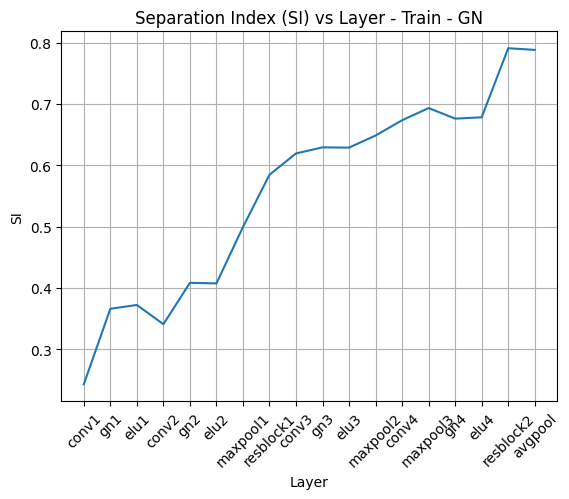

In [11]:
# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in si_layer_train], [si for _, si in si_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Separation Index (SI) vs Layer - Train - GN')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Calc Center Si

In [12]:
csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 972.39it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4478.22it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4236.67it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4255.58it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4496.47it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4364.52it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3149.35it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3280.90it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4504.19it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4242.67it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4459.18it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4068.98it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3050.85it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4017.53it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3296.89it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3194.44it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4435.60it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4222.17it/s]


[('conv1', 0.34279999136924744), ('gn1', 0.3698999881744385), ('elu1', 0.3790999948978424), ('conv2', 0.4074999988079071), ('gn2', 0.41269999742507935), ('elu2', 0.4274999797344208), ('maxpool1', 0.4908999800682068), ('resblock1', 0.5773000121116638), ('conv3', 0.6024999618530273), ('gn3', 0.6060000061988831), ('elu3', 0.6133999824523926), ('maxpool2', 0.6263999938964844), ('conv4', 0.6448000073432922), ('maxpool3', 0.6796000003814697), ('gn4', 0.6468999981880188), ('elu4', 0.6556999683380127), ('resblock2', 0.814799964427948), ('avgpool', 0.8394999504089355)]


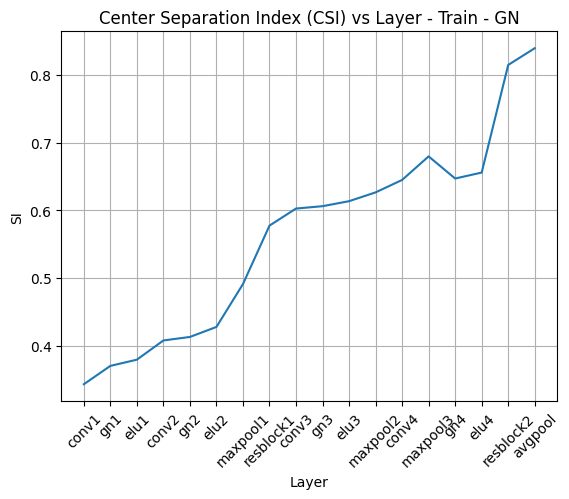

In [13]:
print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer - Train - GN')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## SI and CenterSI layer for Val Loader

In [9]:
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(val_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        # Flatten and concatenate the features for each layer
        features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
    else:
        print(f"No features captured for layer {layer_name}")

# Concatenate the labels
labels = torch.cat(labels_list)

100%|██████████| 20/20 [00:00<00:00, 21.85it/s]


### Calc SI

In [10]:
si_layer_val = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    si = instance_disturbance.si_batch(batch_size=2000)
    si_layer_val.append((layer_name, si))

Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 222.07it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5021.11it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4909.45it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5271.43it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5437.73it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4771.68it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5338.53it/s]

Data has been normalized



Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5199.55it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5280.28it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4967.59it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5115.00it/s]

Data has been normalized



Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5334.00it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5388.83it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4710.94it/s]

Data has been normalized



Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5809.29it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5391.14it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5150.60it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4875.21it/s]


In [11]:
si_layer_val

[('conv1', 0.23559999465942383),
 ('gn1', 0.33319997787475586),
 ('elu1', 0.33879998326301575),
 ('conv2', 0.3059999942779541),
 ('gn2', 0.37439998984336853),
 ('elu2', 0.373199999332428),
 ('maxpool1', 0.46459999680519104),
 ('resblock1', 0.5539999604225159),
 ('conv3', 0.5924000144004822),
 ('gn3', 0.5977999567985535),
 ('elu3', 0.6007999777793884),
 ('maxpool2', 0.6207999587059021),
 ('conv4', 0.6567999720573425),
 ('maxpool3', 0.6759999990463257),
 ('gn4', 0.6575999855995178),
 ('elu4', 0.6597999930381775),
 ('resblock2', 0.8151999711990356),
 ('avgpool', 0.8473999500274658)]

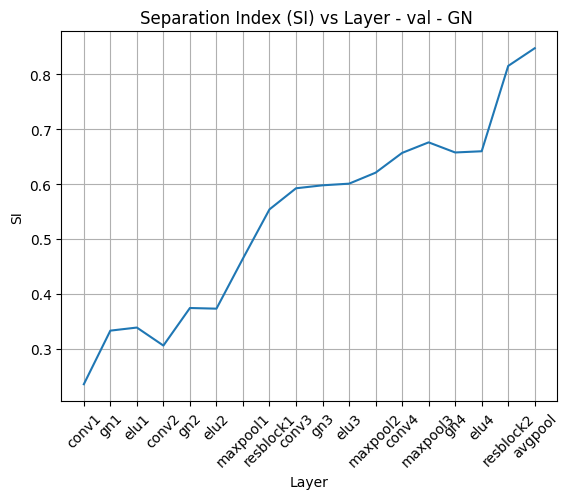

In [12]:
# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in si_layer_val], [si for _, si in si_layer_val])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Separation Index (SI) vs Layer - val - GN ')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### calc Center SI

In [13]:
csi_layer_val = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_val.append((layer_name, csi))

Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 448.84it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3329.69it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2912.71it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3018.93it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3726.06it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2978.20it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3076.51it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3321.78it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3259.82it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3096.95it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3317.40it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3021.11it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3097.71it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2967.67it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3211.57it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3439.83it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3183.13it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 1869.12it/s]


[('conv1', 0.34299999475479126), ('gn1', 0.3771999776363373), ('elu1', 0.382999986410141), ('conv2', 0.4156000018119812), ('gn2', 0.4213999807834625), ('elu2', 0.43719998002052307), ('maxpool1', 0.49799999594688416), ('resblock1', 0.5961999893188477), ('conv3', 0.6233999729156494), ('gn3', 0.6265999674797058), ('elu3', 0.6377999782562256), ('maxpool2', 0.6499999761581421), ('conv4', 0.6660000085830688), ('maxpool3', 0.7051999568939209), ('gn4', 0.6661999821662903), ('elu4', 0.6769999861717224), ('resblock2', 0.8695999979972839), ('avgpool', 0.8973999619483948)]


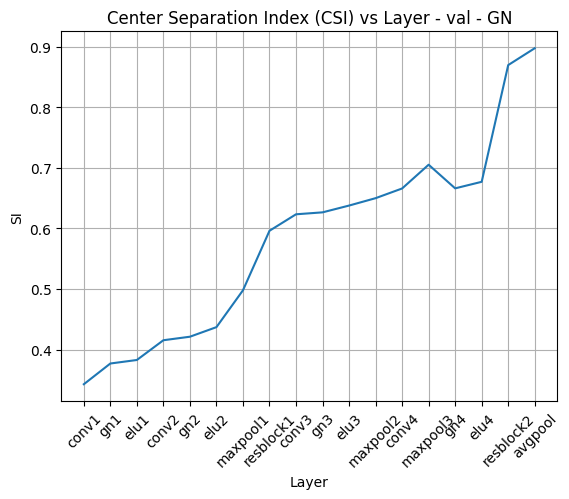

In [14]:
print(csi_layer_val)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_val], [si for _, si in csi_layer_val])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer - val - GN')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## SI and CenterSI layer for Test Loader

In [8]:
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader):
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        # Flatten and concatenate the features for each layer
        features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
    else:
        print(f"No features captured for layer {layer_name}")

# Concatenate the labels
labels = torch.cat(labels_list)

100%|██████████| 40/40 [00:01<00:00, 25.49it/s]


### Calc SI

In [9]:
si_layer_test = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    si = instance_disturbance.si_batch(batch_size=2000)
    si_layer_test.append((layer_name, si))

Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 405.00it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 2171.19it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7426.18it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7568.21it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7035.06it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 8446.04it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7617.70it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7587.38it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7549.14it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7919.76it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7810.62it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7138.03it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7508.60it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6638.66it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7901.85it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7319.90it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7511.29it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7044.51it/s]


In [10]:
si_layer_test

[('conv1', 0.24329999089241028),
 ('gn1', 0.36629998683929443),
 ('elu1', 0.3723999857902527),
 ('conv2', 0.34109997749328613),
 ('gn2', 0.40849998593330383),
 ('elu2', 0.4075999855995178),
 ('maxpool1', 0.49939998984336853),
 ('resblock1', 0.5845999717712402),
 ('conv3', 0.6193000078201294),
 ('gn3', 0.6291999816894531),
 ('elu3', 0.6287999749183655),
 ('maxpool2', 0.6484999656677246),
 ('conv4', 0.6733999848365784),
 ('maxpool3', 0.6931999921798706),
 ('gn4', 0.6759999990463257),
 ('elu4', 0.6782000064849854),
 ('resblock2', 0.7906999588012695),
 ('avgpool', 0.7879999876022339)]

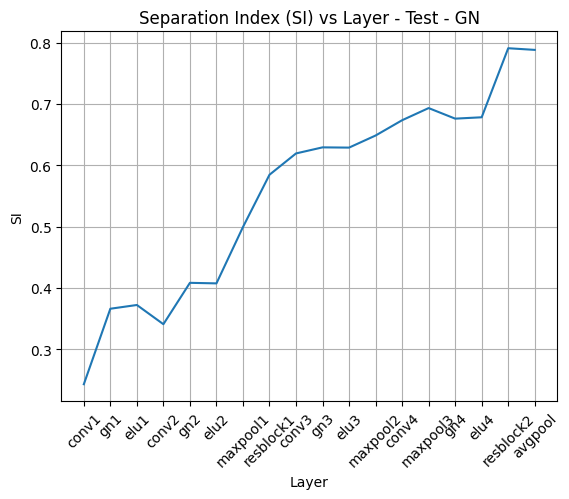

In [11]:
# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in si_layer_test], [si for _, si in si_layer_test])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Separation Index (SI) vs Layer - Test - GN')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Calc Center SI

In [12]:
csi_layer_test = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_test.append((layer_name, csi))

Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 851.01it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4193.47it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4534.38it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4320.46it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4472.49it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4514.86it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3008.39it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3044.20it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4644.85it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4448.77it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4645.88it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4200.18it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3146.51it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4038.42it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3271.18it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3229.37it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4382.76it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4237.53it/s]


[('conv1', 0.34279999136924744), ('gn1', 0.3698999881744385), ('elu1', 0.3790999948978424), ('conv2', 0.4074999988079071), ('gn2', 0.41269999742507935), ('elu2', 0.4274999797344208), ('maxpool1', 0.4908999800682068), ('resblock1', 0.5773000121116638), ('conv3', 0.6024999618530273), ('gn3', 0.6060000061988831), ('elu3', 0.6133999824523926), ('maxpool2', 0.6263999938964844), ('conv4', 0.6448000073432922), ('maxpool3', 0.6796000003814697), ('gn4', 0.6468999981880188), ('elu4', 0.6556999683380127), ('resblock2', 0.814799964427948), ('avgpool', 0.8394999504089355)]


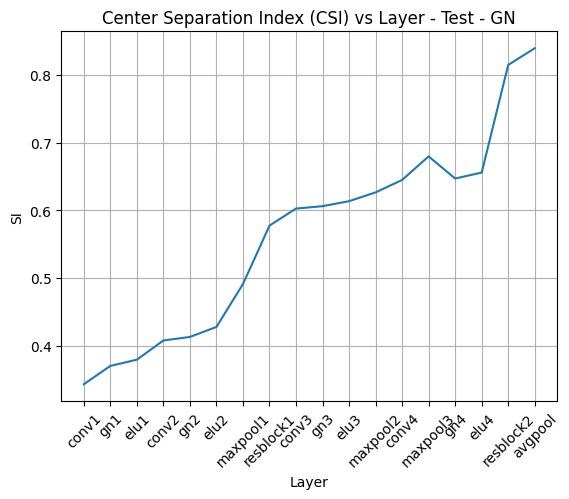

In [13]:
print(csi_layer_test)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_test], [si for _, si in csi_layer_test])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer - Test - GN')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()